# DL Project 2: Defect Detection
**Jacek Karolczak (145446) and Konrad Szewczyk (145466)**

## 1. Problem description and data generation
The code in this section generates a number of time sequences representing a set of measurements conducted by 3 sensons monitoring the production of candies. As can be expected, the production lines are expected to sporadically malfuction, and thus the produced sweets would display some unwanted defects.

As such, our task consists of two parts. Having been given the necessary data, we are first to prepare a predictive model capable of telling whether a given candy has a defect and which defect type in particular. Then, a root cause analysis is to be conducted in order to display what patters in the measurement data are related to particular defects.

There are five different defect types that can be found in the generated data. Four out of them are related to a patters occuring at one sensors - the remaining one is connected with a pattern read by two sensors simultanously.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
n = 50000

In [4]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [5]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)
    

In the cell below, three plots are displayed picturing the examples from generated measurements of the sensors, together with correct classification of 5 potential defect types. As it can be seen, both the patterns and the measurement sequences can be of different lengths.

[False False False False  True]


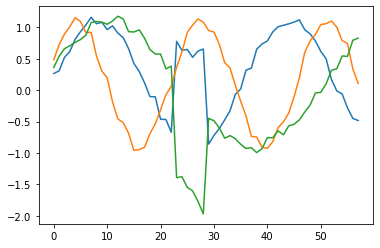

[False False False  True  True]


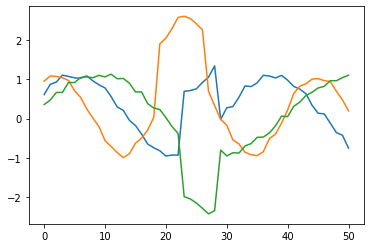

[False False False False False]


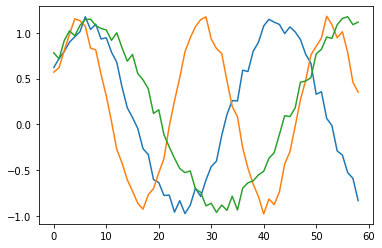

In [6]:
for i in range(3):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

## 2. Implementation
For this project, we are using PyTorch library for our neural networks. Most of the implementation code has been written in the separate source files in */src* folder in order to maintain readability of this report.


In [7]:
import torch
import torch.nn as nn

from src.data import *
from src.explainability import *
from src.metrics import *
from src.model import *

If on a computer is available GPU supporting CUDA most time-consuming computations (on floating-point numbers, the model) are performed on GPU.

In [8]:
print(f"Is cuda available:\t{str(torch.cuda.is_available()).lower()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device:\t{device}")

Is cuda available:	true
Selected device:	cuda


### 2.1 - Dataset and dataloaders
PyTorch provides an easy to use data loading and sampling utility in a form of *DataLoader* class. Before we can use, it is necessary to provide a *dataset* object to load the data from.  

The *dataset* is also split into *train*, *eval* and *test* sets before putting them to the *DataLoader* as we want to ensure that our results represent the real performance of our model.

Because candies (time series) lengths may vary and we don’t want to use padding (use time series just as they are), *DataLoader* creates mini-batches of size 1.

| Set   |   %   |
|---    |---    |
| Train |   60  |
| Eval  |   20  |
| Test  |   20  | 

In [9]:
dataset = Dataset(xl, yl)
train, eval = dataset_split(dataset, train_size=0.6)
eval, test = dataset_split(eval, train_size=0.5)

In [10]:
train_dataloader = torch.utils.data.DataLoader(dataset=train, batch_size=1)
eval_dataloader = torch.utils.data.DataLoader(dataset=eval, batch_size=1)
test_dataloader = torch.utils.data.DataLoader(dataset=test, batch_size=1)

### 2.2 Model
#### Anomaly detection

We propose a very simple deep neural network to solve the problem of predicting whether a given candy has a defect. Our solution consists of two submodules:
- Encoder - this module creates new features by dimensionality expansion (from a number of features of input time series to 32 features) using three stacked bidirectional LSTMs. The encoder is independent of time series length and thus its output length matches one of the input time series.
- Classifier - this module makes a prediction of whether the given candy has any defect. Predictions are made using features extracted by the encoder. The classifier is a quite primitive feedforward neural network consisting of three linear layers and an activation function after each linear layer. As an input classifier takes a tensor of 96 values.

To create input for the classifier it is necessary to transform the output from the encoder because the encoder returns an output of variable length. To achieve compatibility between submodules output and input channel-wise, global pooling is performed using three aggregation functions - minimum, average and maximum. That way from 32 channels and 3 aggregation functions tensor of length 96 is obtained.


In [11]:
clf = Classifier()
_ = clf.to(device)

#### Fitting
Because the problem is not only multilabel but also multiclass we decided to use binary cross-entropy as a criterion. 

During experiments, we found out that the model gives similar results for both - training and evaluation sets, thus no dropout was applied during training. We decided only to use small weight decay to reduce the chances of overfitting. Because we use regularization and we want to use something more sophisticated than SGD we use AdamW as an optimizer.

In the training loop, early stopping is applied if there is no improvement in F1-score over 3 consecutive epochs. The stopping criterion is dependant on F1 as we want both precision and recall to be high.


In [12]:
epochs = 50
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(clf.parameters(), lr=1e-3, weight_decay=1e-4)

In [13]:
eval_f1 = []
for e in range(epochs):
    clf.train()
    ls = []
    for i, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        y_hat = clf(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ls.append(loss)
    print(f"Epoch: {e}")
    print(f"[train] Binary Cross Entropy: {sum(ls) / len(ls):.4f}")
    
    clf.eval()
    serialize(clf, e)
    with torch.no_grad():
        y_true, y_pred = [], []
        for i, (x, y) in enumerate(eval_dataloader):
            x = x.to(device)
            y_hat = clf(x)
            y_hat = y_hat.cpu()                
            y_true.append(y)
            y_pred.append(y_hat)
        
        y_true = torch.cat(y_true, dim=0)
        y_pred = torch.cat(y_pred, dim=0)
        (loss, acc, prec, rec, f1) = compute_metrics(y_true, y_pred)
        eval_f1.append(f1)
        
        print(f"[eval] Binary Cross Entropy: {loss:.4f}, Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")        
        if e >= 4 and all(np.array(eval_f1[-4:-1]) >= eval_f1[-1]):
            print(f"Early stopping")
            break

Epoch: 0
[train] Binary Cross Entropy: 0.3625
[eval] Binary Cross Entropy: 0.3389, Accuracy: 0.8482, Precision: 0.4384, Recall: 0.3054
Epoch: 1
[train] Binary Cross Entropy: 0.2520
[eval] Binary Cross Entropy: 0.1617, Accuracy: 0.9345, Precision: 0.6958, Recall: 0.6048
Epoch: 2
[train] Binary Cross Entropy: 0.0817
[eval] Binary Cross Entropy: 0.0380, Accuracy: 0.9889, Precision: 0.7599, Recall: 0.7546
Epoch: 3
[train] Binary Cross Entropy: 0.0296
[eval] Binary Cross Entropy: 0.0166, Accuracy: 0.9955, Precision: 0.7669, Recall: 0.7617
Epoch: 4
[train] Binary Cross Entropy: 0.0204
[eval] Binary Cross Entropy: 0.0154, Accuracy: 0.9961, Precision: 0.7674, Recall: 0.7629
Epoch: 5
[train] Binary Cross Entropy: 0.0152
[eval] Binary Cross Entropy: 0.0179, Accuracy: 0.9962, Precision: 0.7667, Recall: 0.7638
Epoch: 6
[train] Binary Cross Entropy: 0.0124
[eval] Binary Cross Entropy: 0.0101, Accuracy: 0.9974, Precision: 0.7686, Recall: 0.7639
Epoch: 7
[train] Binary Cross Entropy: 0.0113
[eval] Bi

In [14]:
clf.eval()
with torch.no_grad():
    y_true, y_pred = [], []
    for i, (x, y) in enumerate(test_dataloader):
        x = x.to(device)
        y_hat = clf(x)
        y_hat = y_hat.cpu()                
        y_true.append(y)
        y_pred.append(y_hat)
    
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    (loss, acc, prec, rec, f1) = compute_metrics(y_true, y_pred)
        
    print(f"[test] Binary Cross Entropy: {loss:.4f}, Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")        

[test] Binary Cross Entropy: 0.0165, Accuracy: 0.9961, Precision: 0.7556, Recall: 0.7547


After each epoch model is serialized. If you want to reproduce results and you don’t want to wait a few dozens of minutes to fit the model you can uncomment and execute the cell below to load the trained model.

In [15]:
#clf = deserialize('model.pt')
#_ = clf.to(device)

#### Time series reconstructor

To perform anomaly analysis we reconstruct time series without anomalies. We decided that there is no need to use a deep neural network as we know that defect-free candy should be represented using three sine-like functions and a much simpler optimization algorithm should work as well. Thus we decided to create a simple model expressed by the equation: 

$\text{model} = a + sin{(b\times x + c)}$

To find values of weights `a`, `b` and `c` we use the power of PyTorch.

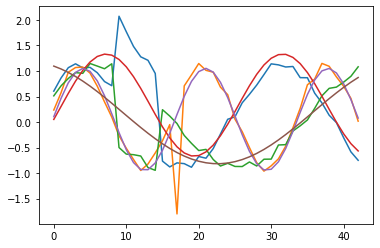

In [16]:
plt.plot(xl[42])
plt.plot(reconstruct(xl[42]))
plt.show()

## 3. Root cause analysis
Root cause analysis is performed in two steps:
- To detect on which variable which anomaly occurs we apply an algorithm that iterates through time-series variables and classifies time series with reconstructed variables. If in reconstructed ts anomaly which occurred in original time series doesn’t occur it classify given variable as an anomaly origin. This procedure is repeated for pair of variables, as there might be anomalies occurring on more than two variables. However, if an anomaly detected on a single variable is detected on two variables it’s not classified again, so the set of variables on which a given anomaly occurs is a minimal set. 
- To detect where (in which interval) anomaly occurs we use an algorithm based on bisection. In each iteration, half of the considered interval is reconstructed. If the anomaly of the given type is no longer detected after reconstruction, the reconstructed area becomes a new considered area. The procedure is repeated as long as the considered interval is reasonably wide or an anomaly starts to occur again. This algorithm works very fast and on average very well but in bad cases (for instance when an anomaly occurs in the middle point of time series), it may fail to find an informative explanation. Thus we apply also the algorithm following the idea but performing splits into three parts. Their results are combined and only the one where the interval is narrower is returned as the final result.

We combined information from both steps and created some visualizations.




Gorundtruth: [False False False False  True]
Classification: [False False False False  True]


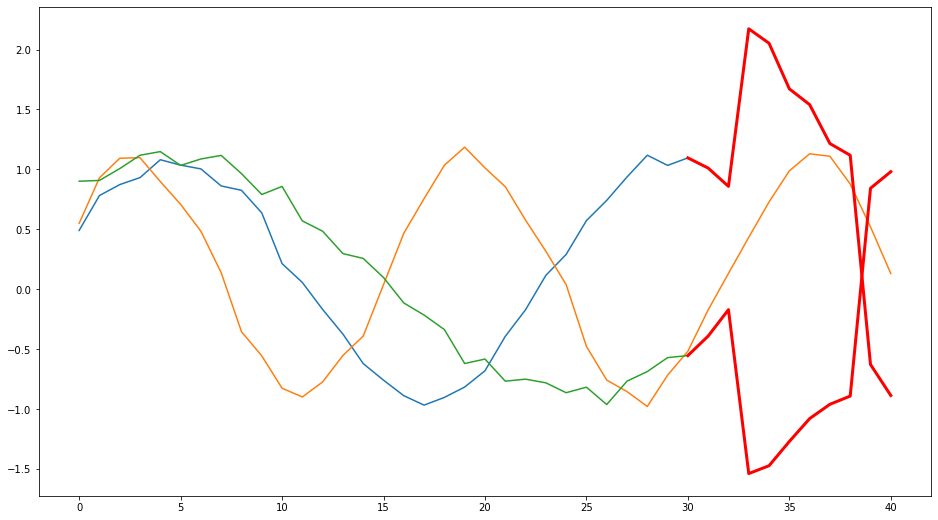

In [17]:
idx = 12
print(f"Gorundtruth: {yl[idx]}")
print(f"Classification: {infer(xl[idx], clf)}")
plot_explanation(xl[idx], yl[idx], clf)

Gorundtruth: [ True False  True False False]
Classification: [ True False  True False False]


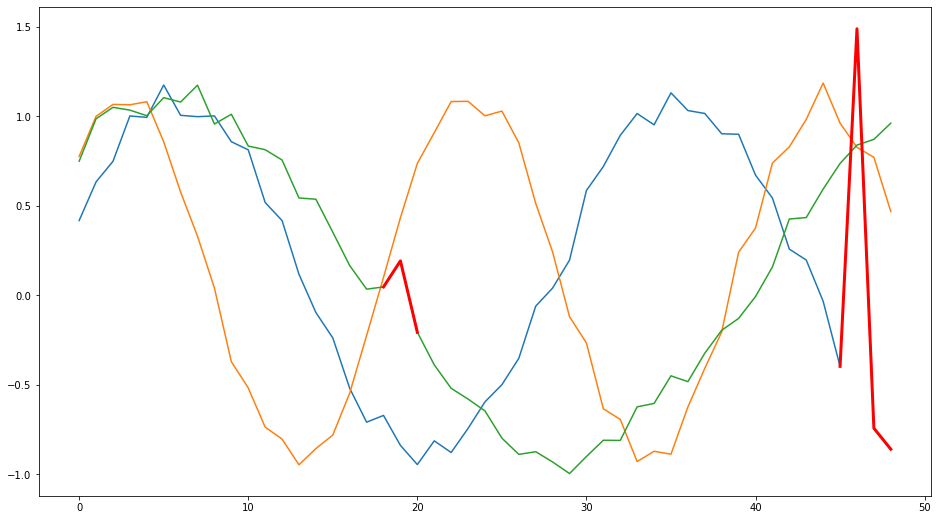

In [18]:
idx = 23
print(f"Gorundtruth: {yl[idx]}")
print(f"Classification: {infer(xl[idx], clf)}")
plot_explanation(xl[idx], yl[idx], clf)

Gorundtruth: [False  True False  True False]
Classification: [False  True False  True False]


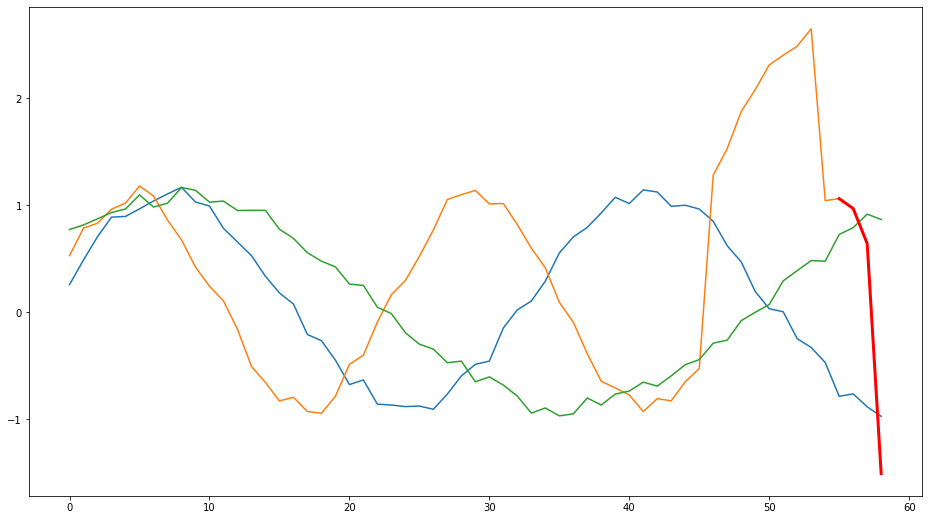

In [19]:
idx = 92
print(f"Gorundtruth: {yl[idx]}")
print(f"Classification: {infer(xl[idx], clf)}")
plot_explanation(xl[idx], yl[idx], clf)